# **Caso de uso:** Aplicación de regresión logística en la ECV 2020

Realizado por: Natalia Macho Simancas

En este caso, se ilustra la aplicación de la técnica de Regresión Logística a unos datos de la Encuesta de Condiciones de Vida (ECV). En concreto, el objetivo que se persigue es, dados los datos, clasificar si un hogar está en riesgo de pobreza o no.

Los datos que se han utilizado son los microdatos de la ECV del año 2020 que recoge el Instituto Nacional de Estadística (INE). Esta encuesta se realiza en todos los países de la Unión Europea bajo los mismos criterios, para así disponer de estadísticas comparativas de la sociedad, las necesidades de la población, la pobreza y desigualdad, y el impacto de las políticas sobre los hogares.

## **0. Instalación de librerías**

Antes de comenzar a desarrollar el análisis de los datos, para poder aplicar determinadas funciones, debemos ejecutar el siguiente código instalando algunas librerías de R que vamos a usar en Collaborate.

In [2]:
install.packages("ggplot2") # Para visualizar gráficos
library(ggplot2)

install.packages("ggcorrplot") # Gráfico de correlaciones
library(ggcorrplot)

install.packages("Epi")
library(Epi)

install.packages("caret") # Para la matriz de confusión
library(caret)

install.packages("ResourceSelection") # Para el test de bondad de ajuste
library(ResourceSelection)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
# Evitar que salgan mensajes warnings en la ejecución del código (si los queremos activar, warn = 1)
options(warn=-1)

## **1. ¿Qué es la Regresión Logística?** 

La regresión logística es una técnica estadística, concretamente un método de clasificación supervisada, que permite predecir el resultado de una variable dicotómica en función de un cierto número de variables independientes. 

Estas variables explicativas pueden ser cuantitativas o cualitativas (que se convertirán en variables dummy) y para que la ecuación del modelo sea lineal, hay que realizar una transformación logarítmica.

La regresión logística modela la probabilidad de que la variable respuesta pertenezca a determinada categoría, es decir, el objetivo general de esta técnica es predecir la probabilidad de un suceso particular: $ p = Pr(Y = k | X = x) $, e identificar las variables regresoras más útiles para esta predicción.

La siguiente expresión, denominada **función logística** permite calcular la probabilidad de dicho suceso, cuyo resultado está siempre comprendido entre 0 y 1:

$$ p = \frac{e^{\beta_{0}+ \beta_{1} X_{1}+...+ \beta_{p} X_{p}}}{1+e^{\beta_{0}+ \beta_{1} X_{1}+...+ \beta_{p} X_{p}}}  (1)$$ 


Esta función describe la forma en que X se relaciona con Y, y produce una curva en forma de S (sigmoide), comprendiéndose los valores de Y entre [0,1].

* Reestructurando esta expresión, se deriva el término de **odds**:

$$ odds = \frac{p}{1-p} = e^{\beta_{0}+ \beta_{1} X_{1}+...+ \beta_{p} X_{p}}$$

* Y tomando logaritmos a esta expresión, se obtiene el **logit**:

$$ logit = log(odds) = log(\frac{p}{1-p}) = \beta_{0}+ \beta_{1} X_{1}+...+ \beta_{p} X_{p}$$

Equivalentemente, esto permite reescribir la expresión de la probabilidad (1) de forma simplificada. Multiplicando el numerador y el denominador por $e^{-logit}$, la fórmula también se puede observar como:

$$ p = \frac{1}{1+ e^{-logit}} $$  

La interpretación de los parámetros del modelo, puede realizarse a través del odds o del logit. Por ejemplo, el coeficiente $\beta_{1}$ indica cuánto cambia el logit cuando varia $X_{1}$, y de forma equivalente, multiplica el odds por $e^{\beta_{1}}$.

Así, para este modelo de regresión logística que voy a ajustar, la variable dependiente dicotómica será el estar en riesgo de pobreza o no, y el objetivo de esta técnica será modelar cómo influyen las variables regresoras en la probabilidad de ocurrencia del suceso particular.


## **2. Lectura y resumen de los datos** 

Los ficheros de microdatos contienen datos individuales anonimizados de una estadística, en este caso, de la ECV, con el fin de mantener la confidencialidad de la información. 

El fichero de microdatos utilizado se puede encontrar en el siguiente enlace:
https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176807&menu=resultados&idp=1254735976608#!tabs-1254736195153

Al descargarlo, obtenemos un fichero en formato .zip con 4 ficheros .zip en su interior, correspondientes a:
*  Fichero D: datos básicos del hogar
*  Fichero R: datos básicos de la persona
*  Fichero H: datos detallados del hogar
*  Fichero P: datos dellatados para los adultos

En este caso, como he decidido hacer el estudio a nivel de hogares, voy a combinar los ficheros D y H, para quedarme, de entre todos los datos disponibles, con sólo 6 variables, combinando variables dicotómicas y numéricas (discretas y continuas), que permitan ilustrar mejor los resultados.

Estas variables son:
*  Renta disponible total del hogar (HY020)
*  Transferencias periódicas percibidas de otros hogares (HY080N)
*  Número de miembros en el hogar (HX040)
*  Si el hogar a final de mes puede ahorrar dinero o no (HC050)
*  Hogar en riesgo de pobreza (vhPobreza)

Todas estas variables se encuentran en el fichero H, por lo que en primer lugar, leemos el fichero.


In [4]:
datosH <- read.csv("ECV_Th_2020.csv", sep="")

# Selecciono las variables con las que quiero trabajar
datos <- datosH[,c("HY020","HY080N","HX040","HC050","vhPobreza")]
dim(datos)

[1] 15043     5

En primer lugar, cambiamos los nombres de las variables para que sea más sencillo su análisis.

In [5]:
# Cambiamos los nombres de las variables 
names(datos) = c("Renta", "Transferencias", "Num_miembros", "Ahorro", "Pobreza")
head(datos)

,Renta,Transferencias,Num_miembros,Ahorro,Pobreza
,<dbl>,<dbl>,<int>,<int>,<int>
1,0.0,0,1,1,1
2,13221.5,0,3,4,1
3,24500.0,0,1,1,0
4,16033.1,0,3,4,1
5,39660.0,0,4,1,0
6,65000.0,0,1,1,0


**> Depuración de los NA's**

En los microdatos hay mucho ruido, por lo que encontramos gran cantidad de valores perdidos (NA's). El tratamiento de los NA's debe hacerse con cuidado, ya que los propios datos faltantes pueden aportar información y su eliminación **introduce un sesgo** a los resultados, ya que se estaría ignorando información importante. Por ejemplo, quizá todas aquellas personas que no han respondido a una cierta pregunta pertenecen a un determinado perfil.

Por lo tanto, los NA's que existen en estos datos se podrían imputar pero como tenemos numerosos registros, para ilustrar este ejemplo decido simplemente borrar las filas que contengan algún NA y de esta forma, me quedo con los datos de aquellos individuos para los que se registró respuesta en todas las variables que son de nuestro interés.

Sin embargo, ha de tenerse en cuenta que esta no sería la forma más apropiada de tratar los NA's ya que introduce el citado sesgo, pero su correcta imputación puede ser objeto de un profundo análisis.

In [6]:
# Elimino la filas con NA's
datos <- na.omit(datos)

dim(datos)

[1] 15005     5

A pesar de haber eliminado registros, seguimos contando con una gran cantidad de observaciones para las 6 variables, más de 15.000, que nos sirve para el objetivo que persigue este cuaderno de ilustrar el funcionamiento de un modelo de Regresión Logística.

**> Análisis descriptivo de los datos**

Antes de ajustar un modelo, vemos un resumen de los datos que vamos a utilizar:

In [7]:
str(datos)

'data.frame':	15005 obs. of  5 variables:
 $ Renta         : num  0 13222 24500 16033 39660 ...
 $ Transferencias: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Num_miembros  : int  1 3 1 3 4 1 4 5 2 4 ...
 $ Ahorro        : int  1 4 1 4 1 1 1 1 1 4 ...
 $ Pobreza       : int  1 1 0 1 0 0 0 0 0 0 ...
 - attr(*, "na.action")= 'omit' Named int [1:38] 1381 1404 1545 2820 2885 2917 2933 2990 3350 3514 ...
  ..- attr(*, "names")= chr [1:38] "1381" "1404" "1545" "2820" ...


In [8]:
summary(datos)

     Renta        Transferencias     Num_miembros        Ahorro     
 Min.   :-36233   Min.   :    0.0   Min.   : 1.000   Min.   :1.000  
 1st Qu.: 16502   1st Qu.:    0.0   1st Qu.: 2.000   1st Qu.:1.000  
 Median : 27524   Median :    0.0   Median : 2.000   Median :2.000  
 Mean   : 31918   Mean   :  166.9   Mean   : 2.527   Mean   :2.479  
 3rd Qu.: 41371   3rd Qu.:    0.0   3rd Qu.: 3.000   3rd Qu.:4.000  
 Max.   :349862   Max.   :40000.0   Max.   :10.000   Max.   :4.000  
    Pobreza      
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.1888  
 3rd Qu.:0.0000  
 Max.   :1.0000  

Vemos que se trata de 2 variables de caracter categórico, 2 numéricas y 1 entera.

También observamos que la renta media disponible en los hogares es 31.918€, que el número medio de miembros en el hogar es 2.52, que la mayoría de hogares a final de mes puede ahorrar dinero y que la mayor parte de los hogares no están en riesgo de pobreza.

**> Gráfico de correlaciones entre variables**

Otro análisis de interés es el de las correlaciones que existen entre variables. Se observa que las variables no están muy correlacionadas entre sí, excepto la variable `Renta` con `Num_miembros`, `Ahorro` y `Pobreza`.

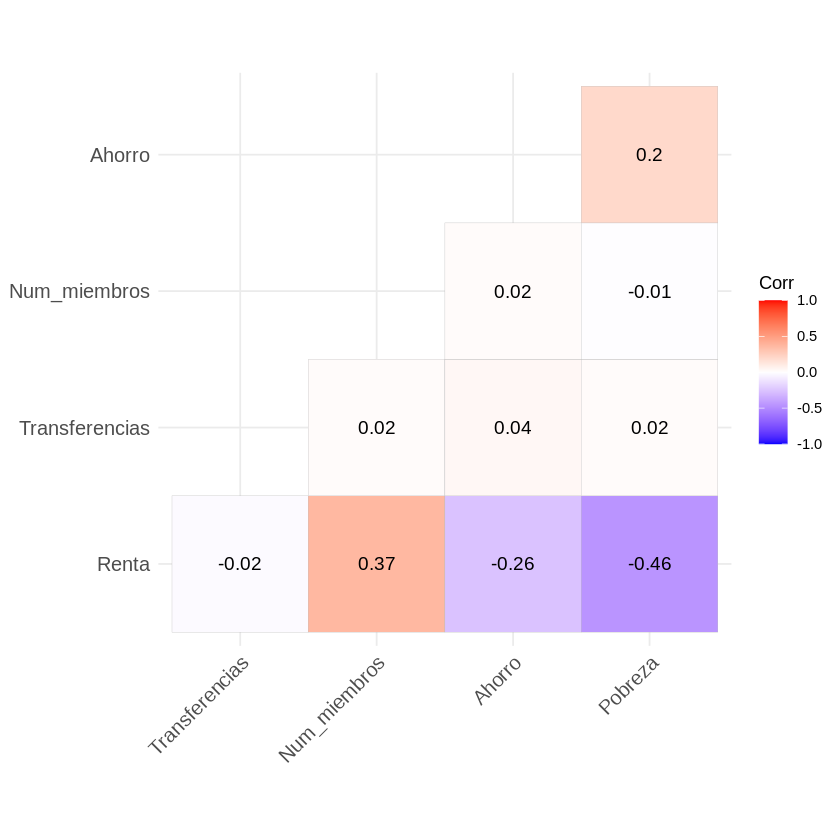

In [9]:
ggcorrplot(cor(datos), type = "lower", lab = T, show.legend = T)

**> Recodificación de datos (Data Wrangling)**

Por otra parte, los valores de las variables categóricas "Ahorro" están codificados de cierta forma que para entenderlos, debemos ir al fichero zip donde los hemos descargado y en otro de los archivos que contiene, encontramos información sobre el significado de cada variable. Para que sea más simple interpretarlos, cambiamos directamente los valores de la variable.

In [10]:
# Modificamos los valores de la variable HC050
datos$Ahorro <- ifelse(datos$Ahorro=="1","Ahorra dinero", ifelse(datos$Ahorro=="2","Necesita usar los ahorros",ifelse(datos$Ahorro=="3","Necesita pedir dinero","Otro")))

Una vez hecho esto, tenemos que tener en cuenta que las variables categóricas que vamos a usar, ninguna está definida como tal, por lo que tendremos que convertirlas antes de ajustar el modelo.

In [11]:
# Antes de ajustar el modelo, hay que convertir a factor
datos$Ahorro<-as.factor(datos$Ahorro)
datos$Pobreza <-as.factor(datos$Pobreza)

## **3. Especificación del modelo** 

En el siguiente apartado voy a ajustar un modelo de Regresión Logística a la muestra completa de 15.005 registros procedentes de la ECV.

* La **variable respuesta** que se quiere predecir es `Pobreza`, que indica si el hogar está en riesgo de pobreza o no.

* Las **variables predictoras** son:
    - Renta disponible total del hogar (`Renta`)
    - Transferencias periódicas percibidas de otros hogares (`Transferencias`)
    - Número de miembros en el hogar (`Num_miembros`)
    - Si el hogar a final de mes puede ahorrar dinero o no (`Ahorro`) 



## **4. Ajuste del modelo de regresión logística** 

Comenzamos por modelizar la variable respuesta `Pobreza` a partir de cuatro predictores: la renta disponible, las transferencias periódicas percibidas, el número de miembros en el hogar y el ahorro del hogar.

El ajuste del modelo se realiza por máxima verosimilitud. 

In [12]:
modelo <- glm(Pobreza ~ Renta+Transferencias+Num_miembros+Ahorro, data = datos, family = "binomial")
summary(modelo)


Call:
glm(formula = Pobreza ~ Renta + Transferencias + Num_miembros + 
    Ahorro, family = "binomial", data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.5845  -0.0001   0.0000   0.0000   3.1955  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.170e+01  4.934e-01  23.709  < 2e-16 ***
Renta                           -2.022e-03  8.052e-05 -25.106  < 2e-16 ***
Transferencias                  -1.771e-04  6.480e-05  -2.733  0.00627 ** 
Num_miembros                     8.153e+00  3.319e-01  24.568  < 2e-16 ***
AhorroNecesita pedir dinero     -1.903e-01  2.491e-01  -0.764  0.44503    
AhorroNecesita usar los ahorros  6.592e-01  2.552e-01   2.583  0.00980 ** 
AhorroOtro                       4.293e-01  1.665e-01   2.579  0.00992 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 14539.4

En este caso, el ahorro en el hogar es una variable categórica, por lo que hay que tener en cuenta la codificación de la variable a la hora de interpretar el modelo. Esta variable tenía c=4 categorías, y al entrar en el modelo, se convierten en c-1=3 variables dummy, siendo la categoría base el que el hogar "puede ahorrar".

La ecuación del modelo es:

$$ log(\frac{\hat{p}}{1-\hat{p}}) = 11.7 - 0.002 Renta - 0.0001 Transferencias + 8.15 Num_{miembros} - 0.19 Pedir_{dinero} + 0.65 Usar_{ahorros} + 0.43Otro $$


**a) Interpretación de los coeficientes**
*  El coeficiente estimado para la intersección es el valor esperado del logit de que un hogar de 0 miembros se encuentre en riesgo de pobreza teniendo una renta nula, ninguna transferencia, y capacidad para ahorrar a fin de mes. En este sentido, como era de esperar, el odds es $e^{11.67}$, lo que se corresponde con una probabilidad de $p = \frac{e^{11.7}}{1+e^{11.7}} = 0.9999$. Es decir, casi con total seguridad, un hogar de dichas características se encontrará en situación de pobreza.
*  El coeficiente estimado para Renta es significativo, y negativo. Es decir, el logit de que un hogar tenga riesgo de pobreza está negativamente relacionado con el valor de su renta, de modo que por cada unidad que se incremente la variable Renta, se espera que el logit descienda en promedio 0'002 unidades o equivalentemente, el odds se multiplique por $e^{-0.002}$.
*  El coeficiente estimado para Trasnsferencias es significativo, y también negativo. Es decir, el logit de que un hogar tenga riesgo de pobreza está negativamente relacionado con el valor de las transferencias que recibe, de modo que por cada unidad que se incremente la variable Renta, se espera que el logit descienda en promedio 0'0003 unidades o equivalentemente, el odds se multiplique por $e^{-0.0003}$.
*  El coeficiente estimado para el Nº de miembros en el hogar es significativo y positivo. Es decir, el logit de que un hogar tenga riesgo de pobreza está positivamente relacionado con el número de personas que lo componen, por lo que por cada unidad que se incremente la variable, se espera que el logit aumente en promedio 8.28 unidades o equivalentemente, el odds aumente al multiplicarse por $e^{8.15}$.
*  El coeficiente estimado para Pedir_dinero es negativo, es decir, hogares que a final de mes necesitan pedir dinero tendrían menor riesgo de pobreza. Además, no es significativo en este caso; esta variable no aporta ganancia al modelo sino que al contrario, mete ruido.
*  El coeficiente estimado para Usar_ahorros es significativo y positivo, e indica que 0.65 es la diferencia en el logit entre hogares que necesitan usar los ahorros y aquellos que no lo necesitan. Es decir, los hogares que necesitan Usar_ahorros tienen una posibilidad $e^{0.65}$ veces mayor de estar en riesgo de pobreza.


Se observa que todas las variables son significativas, excepto la categoría Pedir_dinero, pues su p-valor es muy grande, superior al 0.4. Por lo tanto, como la variable no es significativa y además, su interpretación es ilógica, eliminamos la variable Ahorro con una nueva especificación y ajuste del modelo, para ver si mejora.

## **5. Especificación del modelo** 

Como una de las categorías de la variable `Ahorro` no era significativa, eliminamos dicha variable del modelo.

En el siguiente apartado voy a ajustar un nuevo modelo de Regresión Logística a la muestra completa de 15.005 registros procedentes de la ECV.

* La **variable respuesta** que se quiere predecir es `Pobreza`, que indica si el hogar está en riesgo de pobreza o no.

* Las **variables predictoras** son:
    - Renta disponible total del hogar (`Renta`)
    - Transferencias periódicas percibidas de otros hogares (`Transferencias`)
    - Número de miembros en el hogar (`Num_miembros`)




## **6. Ajuste del modelo de regresión logística** 

Volvemos a modelizar la variable respuesta `Pobreza`, pero esta vez a partir de tres predictores: la renta disponible, las transferencias periódicas percibidas y el número de miembros en el hogar.

El ajuste del modelo se realiza por máxima verosimilitud. 

In [13]:
modelo1 <- glm(Pobreza ~ Renta+Transferencias+Num_miembros, data = datos, family = "binomial")
summary(modelo1)


Call:
glm(formula = Pobreza ~ Renta + Transferencias + Num_miembros, 
    family = "binomial", data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.6185  -0.0002   0.0000   0.0000   3.2275  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     1.188e+01  4.832e-01  24.598  < 2e-16 ***
Renta          -2.002e-03  7.957e-05 -25.163  < 2e-16 ***
Transferencias -1.877e-04  6.504e-05  -2.885  0.00391 ** 
Num_miembros    8.070e+00  3.275e-01  24.642  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 14539.4  on 15004  degrees of freedom
Residual deviance:  1461.3  on 15001  degrees of freedom
AIC: 1469.3

Number of Fisher Scoring iterations: 12


La ecuación del modelo es:

$$ log(\frac{\hat{p}}{1-\hat{p}}) = 11.8 - 0.002 Renta - 0.0001 Transferencias + 8.07 Num_{miembros} $$


**a) Interpretación de los coeficientes**
*  El coeficiente estimado para la intersección es el valor esperado del logit de que un hogar de 0 miembros se encuentre en riesgo de pobreza teniendo una renta nula y ninguna transferencia. En este sentido, como era de esperar, el odds es $e^{11.8}$, lo que se corresponde con una probabilidad de $p = \frac{e^{11.8}}{1+e^{11.8}} = 0.9999$. Es decir, casi con total seguridad, un hogar de dichas características se encontrará en situación de pobreza.
*  El coeficiente estimado para Renta es significativo, y negativo. Es decir, el logit de que un hogar tenga riesgo de pobreza está negativamente relacionado con el valor de su renta, de modo que por cada unidad que se incremente la variable Renta, se espera que el logit descienda en promedio 0'002 unidades o equivalentemente, el odds se multiplique por $e^{-0.002}$.
*  El coeficiente estimado para Transferencias es significativo, y también negativo. Es decir, el logit de que un hogar tenga riesgo de pobreza está negativamente relacionado con el valor de las transferencias que recibe, de modo que por cada unidad que se incremente la variable Renta, se espera que el logit descienda en promedio 0'0003 unidades o equivalentemente, el odds se multiplique por $e^{-0.0003}$.
*  El coeficiente estimado para el Nº de miembros en el hogar es significativo y positivo. Es decir, el logit de que un hogar tenga riesgo de pobreza está positivamente relacionado con el número de personas que lo componen, por lo que por cada unidad que se incremente la variable, se espera que el logit aumente en promedio 8.28 unidades o equivalentemente, el odds aumente al multiplicarse por $e^{8.15}$.

También podemos calcular los intervalos de confianza para los valores de los parámetros, a través del siguiente código.

In [ ]:
# IC para los parámetros
confint(modelo1)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),10.9695386190,1.286468e+01
Renta,-0.0021640494,-1.851937e-03
Transferencias,-0.0003171121,-6.125865e-05
Num_miembros,7.4517159799,8.736338e+00


**b) Bondad de ajuste del modelo**

Para comprobar si el modelo ajustado es bueno o no, podemos hacer el test de Hoslem, donde las hipótesis del contraste son:

$H_0:$ No hay relación entre las variables

$H_1:$ Hay relación entre las variables


In [ ]:
hoslem.test(datos$Pobreza, predict(modelo1, type="response"))


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  datos$Pobreza, predict(modelo1, type = "response")
X-squared = 15005, df = 8, p-value < 2.2e-16


El p-valor devuelto por el test de Hoslem es prácticamente 0, lo que permite rechazar la  $H_0$, e indica que el modelo ajustado es suficientemente bueno.

**c) Comparación de predicciones y observaciones**

Para poder comprobar la eficacia del modelo ajustado, calculamos las predicciones que realiza, estableciendo como punto de corte 0.5, por lo que aquellas probabilidades mayores que dicho valor serán clasificadas como 1 (en riesgo de pobreza) y aquellas con valor menor, se clasificarán como 0.

In [18]:
# Obtener las predicciones
probs <- predict(modelo, datos, type="response") # type = "response" devuelve las predicciones en forma de probabilidad
pred <- as.factor(ifelse(probs>0.5,"1","0"))

Al calcular la **matriz de confusión**, se observa que la capacidad predictiva del modelo es muy alta. La exactitud del modelo (fracción de predicciones que el modelo realizó correctamente) es del 98.18%.

De los 12.172 hogares que no están en riesgo de pobreza, clasifica correctamente a 12.021, mientras que de los 2.833 que sí lo están, clasifica bien a 2.711 hogares. Además, la contradiagonal está muy equilibrada, es decir, el modelo se equivoca casi por igual en predecir el 0 y el 1.



De entre todos los demás ratios que obtenemos, es de interés destacar dos de ellos:

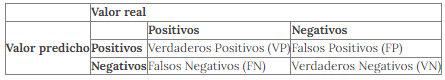

*  <ins> Sensitividad: </ins> también se le conoce como Tasa de verdaderos positivos, y corresponde a los valores predichos por el modelo como positivos y que efectivamente, corresponden a un valor positivo. En este caso, se calcula:

$$ \frac{12.021}{12.172} = 0.987 $$

*  <ins> Especificidad: </ins> es la Tasa de verdaderos negativos, y corresponde a la proporción de verdaderos negativos estimados como negativos.

$$ \frac{2.711}{2.833} = 0.956 $$

In [19]:
# Matriz de confusión
confusionMatrix(pred, datos$Pobreza)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12021   122
         1   151  2711
                                          
               Accuracy : 0.9818          
                 95% CI : (0.9795, 0.9839)
    No Information Rate : 0.8112          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9408          
                                          
 Mcnemar's Test P-Value : 0.09014         
                                          
            Sensitivity : 0.9876          
            Specificity : 0.9569          
         Pos Pred Value : 0.9900          
         Neg Pred Value : 0.9472          
             Prevalence : 0.8112          
         Detection Rate : 0.8011          
   Detection Prevalence : 0.8093          
      Balanced Accuracy : 0.9723          
                                          
       'Positive' Class : 0               
                  

El objetivo es encontrar el punto de corte (lo habíamos definido en 0.5) que maximiza la sensitividad y especificidad, aquel para el que el error del modelo es mínimo. Para ello, empleamos la curva ROC.




**> Curva ROC**

La curva ROC es un gráfico que da una medida del poder predictivo del modelo, y relaciona la Sensitividad - Especificidad para todos los posibles puntos de corte. A través de la curva ROC, cuanto mayor sea el área por debajo de la curva, mejor clasificado estará el modelo. 

Se observa que el punto de corte óptimo es 0.321. Tomando este punto de corte se mejora de forma global el modelo, pero a costa de reducir la sensitividad o la especificidad para buscar ese equilibrio entre ambos ratios. 

Por lo tanto, en estos casos, hay que barajar el coste del error que conlleva este cambio en el punto de corte, ya que por ejemplo, en temas médicos puede suponer un error el dar o no cierta medicación a un paciente. Sin embargo, en este caso, no hay un coste del error tan significativo, por lo que sabiendo esto, continuaré la ilustración del análisis del modelo con el punto de corte definido en 0.5.

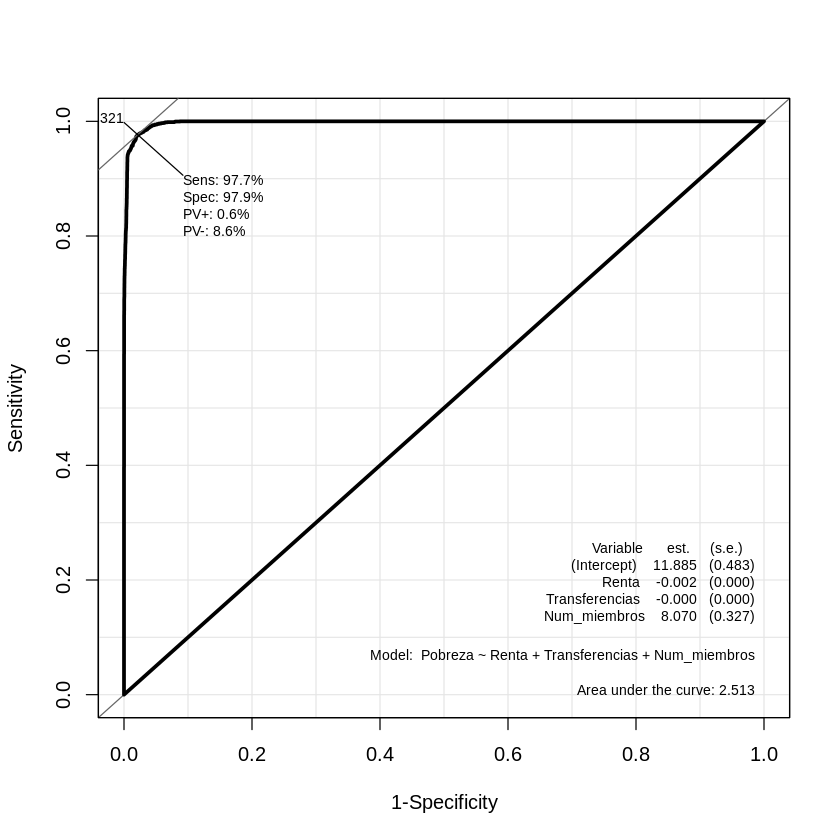

In [20]:
# Curva ROC
ROC(form=Pobreza~Renta+Transferencias+Num_miembros, data=datos, plot="ROC", lwd=3, cex=1.5)

**d) Gráfico de las probabilidades**

Los valores observados y predichos calculados podemos plasmarlos en un gráfico, donde vemos que, en general, con el modelo se obtienen muy buenas clasificaciones. Sin embargo, podemos ver algunos puntos mal clasificados, que son los errores que hemos podido observar en la matriz de confusión.

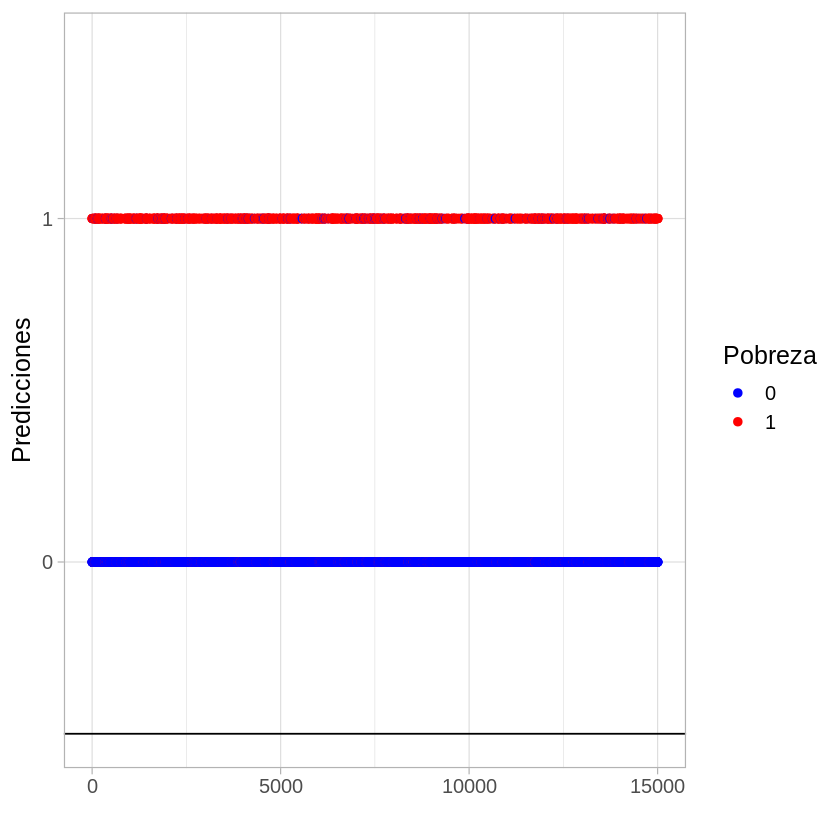

In [21]:
ggplot(datos,aes(x=1:nrow(datos),y=pred,color=Pobreza)) + 
  theme_light(base_size = 15) +
  geom_point(size=2) + 
  scale_color_manual(values=c("blue","red")) +
  xlab(" ") +
  ylab("Predicciones") +
  geom_hline(yintercept=0.5)

**e) Tasa de error del modelo**

Finalmente, ponemos a prueba el modelo ajustado calculando el error que comete, dividiendo el total de errores que comete el modelo entre el total de datos.

In [22]:
# Error del conjunto test
TEE <- sum(pred != datos$Pobreza)/nrow(datos)
round(TEE, 3)

[1] 0.018

En este caso, el error es del 1.8%, un valor muy pequeño que indica el casi perfecto funcionamiento del modelo ajustado para predecir la pobreza de un hogar en base a los tres predictores.

## **7. Conclusiones** 

Con el modelo final ajustado podemos saber la probabilidad de que dadas unas determinadas características, el hogar esté en riesgo de pobreza.

$$ logit = 11.8 - 0.002 Renta - 0.0001 Transferencias + 8.07 Num_{miembros} $$

$$ P(pobreza) = \frac{1}{1+e^{-11.8 + 0.002 Renta + 0.0001 Transferencias - 8.07 Num_{miembros}}} $$

Atendiendo e interpretando el signo de los coeficientes de los predictores estimados y significativos, sabemos que:

*  Cuanto mayor es la renta, menor es la probabilidad de que el hogar esté en riesgo de pobreza, y viceversa. Esto coincide con la intuición, ya que los ingresos limitan la capacidad de las familias de satisfacer sus necesidades básicas, y por tanto, cuanto mejor esté la economía del hogar, menor será la vulnerabilidad económica del hogar.

*  Cuanto mayores son las transferencias que recibe un hogar, menor es la probabilidad de que esté en riesgo de pobreza. De nuevo, esto coincide con la lógica, ya que las transferencias contribuyen a aumentar la economía del hogar, y en un hogar de ciertas características y compuesto por un determinado número de personas, cuanto mayores sean los ingresos percibidos, más capacidad tienen las familias de enfrentar gastos e imprevistos, y mejor será su calidad de vida.

*  Cuanto mayor es el número de miembros que habita en el hogar, más opciones hay de que el hogar se encuentre en riesgo de pobreza. Esto vuelve a ser lo que se esperaba, ya que dada una condición económica, un hogar donde vive una sola persona tendrá menos gastos y podrá vivir mejor en términos económicos que si en el mismo hogar viven 5 personas.

Por lo tanto, tras haber analizado e interpretado el coeficiente de cada variable, se observa que los resultados que hemos obtenidos son lógicos.



Para concluir, podemos extraer aquellos perfiles de hogares que tienen más probabilidad de estar en riesgo de pobreza y aquellos que menor probabilidad tienen.

*  Los hogares con mayor probabilidad de estar en riesgo de pobreza son aquellos con renta y transferencias bajas/nulas, compuesto por un mayor número de miembros.
*  Por otra parte, los hogares con menor probabilidad de estar en riesgo de pobreza son aquellos con mayores rentas y transferencias económicas, y un bajo número de miembros en el hogar.